# Classification for place de marché : TransferLearning using VGG16 model

Now the feasability is established, we will continue to supervised classification

We will : 
- Split our data set
- Augment our data
- Optimize hyperparameters
- Train our model
- Predict our classes

In [3]:
# classic Librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import shutil


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn import cluster
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from sklearn.metrics.cluster import adjusted_rand_score

from sklearn.model_selection import StratifiedShuffleSplit

# librairies for NLP
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras import metrics as kmetrics
from tensorflow.keras import layers,callbacks
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory,plot_model
from tensorflow.keras.applications.vgg16 import VGG16
import keras_tuner

# image imports
from matplotlib.image import imread
import PIL
from PIL import Image, ImageFilter, ImageEnhance

import cv2

In [5]:
# Using the dataset to prepare the subset "data_img"

data = pd.read_csv("data/flipkart_com-ecommerce_sample_1050.csv")
data['general_category'] = data['product_category_tree'].map(lambda x: x.strip('["]').split(' >> ')[0])
data_img = pd.DataFrame()
data_img['image'] = data['image']
data_img['category'] = data['general_category']
data_img['img_path'] = [os.path.join('data/Images/', filename) for filename in data_img['image']]
data_img.head()

,image,category,img_path
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,data/Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,data/Images/7b72c92c2f6c40268628ec5f14c6d590.jpg
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,data/Images/64d5d4a258243731dc7bbb1eef49ad74.jpg
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,data/Images/d4684dcdc759dd9cdf41504698d737d8.jpg
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,data/Images/6325b6870c54cd47be6ebfbffa620ec7.jpg


We will split our data in train/test/val directories, and each of them will contain a directory according to the classes to be predicted

In [7]:
#List of categories
categories = data_img["category"].unique().tolist()

#Ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# images paths
image_dir = './data/Images/'

# supervised directory 
supervised_dir = './data/Images_supervised/'

# folders creation
for category in categories:
    os.makedirs(os.path.join(supervised_dir, 'train', category), exist_ok=True)
    os.makedirs(os.path.join(supervised_dir, 'validation', category), exist_ok=True)
    os.makedirs(os.path.join(supervised_dir, 'test', category), exist_ok=True)

# paths to datasets
train_dir = f'{supervised_dir}train'
validation_dir = f'{supervised_dir}validation'
test_dir = f'{supervised_dir}test'

for category in categories:
    # filter image by category
    category_images = data_img[data_img['category'] == category]['image'].tolist()

    # Divide between train, validation, and test
    train_images, test_val_images = train_test_split(category_images, test_size=val_ratio + test_ratio, random_state=22)
    val_images, test_images = train_test_split(test_val_images, test_size=test_ratio / (val_ratio + test_ratio), random_state=22)

    # Move image to relevant folder
    for img in train_images:
        src = os.path.join(image_dir, img)
        dst = os.path.join(supervised_dir, 'train', category, img)
        shutil.copy(src, dst)

    for img in val_images:
        src = os.path.join(image_dir, img)
        dst = os.path.join(supervised_dir, 'validation', category, img)
        shutil.copy(src, dst)

    for img in test_images:
        src = os.path.join(image_dir, img)
        dst = os.path.join(supervised_dir, 'test', category, img)
        shutil.copy(src, dst)

### Model Creation

Attention !\
 Don't use ImageDataGenerator instead of keras.Sequential : better readability, can go back to original image

In [50]:
def model_build(verbose=True):
    #define a model
    model_base=VGG16(weights="imagenet", 
                     input_shape=(224, 224, 3), 
                     include_top=False)
    
    for layer in model_base.layers:
      layer.trainable = False
    #model_base.trainable=False
    
    data_augmentation = tf.keras.Sequential([
      layers.RandomFlip("horizontal",input_shape=(224, 224, 3)),
      layers.RandomRotation(0.2),
      layers.RandomContrast(0.5),
      ])
    
    
    model = keras.Sequential([
        # Preprocessing
        data_augmentation,
        # Base
        model_base,
        # Head
        #layers.Flatten(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        #layers.Dropout(0.2),
        layers.Dense(7, activation='softmax'),
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), #1e-3
        loss="categorical_crossentropy",
        metrics=['accuracy'],
    )
    model.build(input_shape=(None,224, 224, 3))
    if verbose:
        print(model.summary())

    return model

In [60]:
model = model_build()

C:\Users\kanam\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [57]:
"""plot_model(model, 
show_shapes=True, 
show_layer_names=True,
show_layer_activations=True)"""

'plot_model(model, \nshow_shapes=True, \nshow_layer_names=True,\nshow_layer_activations=True)'

Séparation entre train et test

CF documentaion on image_dataset_from_directory

In [11]:
X_train = image_dataset_from_directory(
                    directory="data/Images_supervised/train/",
                    labels='inferred',
                    label_mode='categorical',
                    class_names=None,
                    batch_size=400,
                    image_size=(224, 224))

Found 735 files belonging to 7 classes.


In [13]:
X_test = image_dataset_from_directory(
                    directory="data/Images_supervised/test/",
                    labels='inferred',
                    label_mode='categorical',
                    class_names=None,
                    batch_size=400,
                    shuffle=False,
                    image_size=(224, 224))

Found 161 files belonging to 7 classes.


In [15]:
X_val = image_dataset_from_directory(
                    directory="data/Images_supervised/validation/",
                    labels='inferred',
                    label_mode='categorical',
                    class_names=None,
                    batch_size=400,
                    image_size=(224, 224))

Found 154 files belonging to 7 classes.


### Optimization

Will now search for opitmized batch and epochs hyperparameters 

In [ ]:
"""
# optimization loop 1
very_min_improvement = 0.01
very_epochs_to_wait = 5
very_early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=very_min_improvement, 
                                              patience=very_epochs_to_wait)

best_params = {"batch":999, 
               "epoch":999,
               "best_epoch":999,
              "val_loss":999}

batch_list = np.arange(16, 18)

time1 = time.time()

for batch_size in batch_list:
   # start anew each batch ? 
    K.clear_session() #clear previous models in memory
    model = model_build(verbose=False) #reset model AND weight
    very_early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
                                                  min_delta=very_min_improvement, 
                                                  patience=very_epochs_to_wait, 
                                                  start_from_epoch=6)
    for epochs_size in range(20, 30, 5):
        
        K.clear_session() #clear previous models in memory
        model = model_build(verbose=False) #reset model AND weight
        very_early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
                                                  min_delta=very_min_improvement, 
                                                  patience=very_epochs_to_wait, 
                                                  start_from_epoch=6)
        
        print(f'CURRENT batch : {batch_size} / epoch : {epochs_size}')
        history = model.fit(X_train,
                      validation_data=X_val,
                      epochs=epochs_size,
                      batch_size=batch_size,
                      verbose=1,
                      callbacks=[very_early_stopping])
        
        for i in history.history['val_loss']:
            current = history.history['val_loss'].index(i)+1
            if i < best_params["val_loss"]:
                    if i < best_params["epoch"]:
                        best_params["batch"] = batch_size
                        best_params["epoch"] = epochs_size
                        best_params["best_epoch"] = current
                        best_params["val_loss"] = i

        print(best_params)
    

#print(f'best_params : batch size is {best_batch}, epoch is {best_epoch}')
time2 = np.round(time.time() - time1, 2)
print(f"Optimization loop tested {len(batch_list)} batches and took {time2} seconds")
print(best_params)"""
print("commented loop 1")

In [166]:
# optimization loop 2
# this loop focuses on batch optimization and let epoch runs until the callback.
# it's a more resource-taxing method, but as it should be used only for optimization, it is acceptable
# the training_history dict allows to browse through the different results, if training time is slightly preferable over quality
very_min_improvement = 0.01
very_epochs_to_wait = 5
very_early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=very_min_improvement, 
                                              patience=very_epochs_to_wait)

EPOCHS = 30

training_history = {}

batch_list = np.arange(16, 45)

time1 = time.time()
iteration = 0
for batch_size in batch_list:
    #prepping index
    y = iteration
    iteration+=1
    #reset model and memory
    K.clear_session() #clear previous models in memory
    model = model_build(verbose=False) #reset model AND weight
    very_early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=very_min_improvement, 
                                              patience=very_epochs_to_wait, 
                                              start_from_epoch=6)
    #reset params
    best_params = {"batch":999, 
               "epoch":EPOCHS,
               "best_epoch":999,
              "val_loss":999}
    
    print(f'CURRENT batch size : {batch_size}')

    history = model.fit(X_train,
                  validation_data=X_val,
                  epochs=EPOCHS,
                  batch_size=batch_size,
                  verbose=1,
                  callbacks=[very_early_stopping])
    
    for i in history.history['val_loss']:
        current = history.history['val_loss'].index(i)+1
        if i < best_params["val_loss"]:
            if i < best_params["epoch"]:
                best_params["batch"] = batch_size
                best_params["best_epoch"] = current
                best_params["val_loss"] = i

    print(best_params)
    training_history[y] = best_params
    
time2 = np.round(time.time() - time1, 2)
print(f"Optimization loop tested {len(batch_list)} batches sizes and took {time2} seconds")
print(best_params)

CURRENT batch size : 16
Epoch 1/30


C:\Users\kanam\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 32s 21s/step - accuracy: 0.1774 - loss: 7.4646 - val_accuracy: 0.3506 - val_loss: 3.9468
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 22s/step - accuracy: 0.3470 - loss: 4.1549 - val_accuracy: 0.5000 - val_loss: 2.7156
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 22s/step - accuracy: 0.5051 - loss: 2.2292 - val_accuracy: 0.6429 - val_loss: 1.9790
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 22s/step - accuracy: 0.6206 - loss: 1.7817 - val_accuracy: 0.7273 - val_loss: 1.6126
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 22s/step - accuracy: 0.7088 - loss: 1.2709 - val_accuracy: 0.7143 - val_loss: 1.4072
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 24s/step - accuracy: 0.7564 - loss: 1.0625 - val_accuracy: 0.7532 - val_loss: 1.3474
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 47s 24s/step - accuracy: 0.7703 - loss: 1.1301 - val_accuracy: 0.7597 - val_loss: 1.3527
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 23s/step - accuracy: 0.7723 - loss: 0.9303 - val_accuracy: 0.7857 - val_loss: 1.3583
Epoch 9/30


SIDE NOTE : should reset the model each batch testing because the training and learning \
goes through EVERY TIME hence the last batches are overfitting because the model is retrained for the humptienth time 

Known problem of Keras, avoided by clearing session with K.clear_session() \
EDIT : Seems to not reset weight, which is inconvenient to optimize properly. We will fall back on a brute force approach : initialize a new model each loop

In [69]:
"""#after optimization loop 1
#extracting best values
best_nb_epoch = best_params["epoch"]
best_batch_size = best_params["batch"]
best_params
"""

In [204]:
#after optimization loop 2
#finding best training in dictionnary
best_index = 0
for i in training_history:
    if training_history[i]['val_loss'] < best_val_loss:
        best_index = i

#attribution of values
best_batch_size = training_history[i]["batch"]
best_nb_epoch = training_history[i]["best_epoch"]
print(best_batch_size, best_epoch)

44 26


### Fit and predict

In [220]:
# define how long to wait before interruption
min_improvement = 0.001
epochs_to_wait = 10
early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                       min_delta=min_improvement,
                                       patience=epochs_to_wait,
                                       restore_best_weights=True)

In [222]:
#reset model after optimizations
model = model_build()

C:\Users\kanam\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [224]:
history = model.fit(X_train,
                  validation_data=X_val,
                  epochs=best_nb_epoch,
                  batch_size=best_batch_size,
                  verbose=1,
                  callbacks=[early_stopping])

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 27s/step - accuracy: 0.1572 - loss: 7.1230 - val_accuracy: 0.2143 - val_loss: 7.4005
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 24s/step - accuracy: 0.2904 - loss: 4.3981 - val_accuracy: 0.4026 - val_loss: 5.5306
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 43s 24s/step - accuracy: 0.4193 - loss: 3.4285 - val_accuracy: 0.5390 - val_loss: 3.4202
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 43s 24s/step - accuracy: 0.5802 - loss: 2.0915 - val_accuracy: 0.6299 - val_loss: 2.0931
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 43s 24s/step - accuracy: 0.6789 - loss: 1.7155 - val_accuracy: 0.6623 - val_loss: 1.9797
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 43s 24s/step - accuracy: 0.6775 - loss: 1.6600 - val_accuracy: 0.6948 - val_loss: 1.8359
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 43s 24s/step - accuracy: 0.7175 - loss: 1.4813 - val_accuracy: 0.6753 - val_loss: 1.7908
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 43s 23s/step - accuracy: 0.7411 - loss: 1.0224 - val_accuracy: 0.6948 - val_loss: 1.7262


Several tests presented different results \
Somtimes the early stopping function stops at 25, sometimes 38, and sometimes not at all \
We will limit to 60 epochs, in order to search within our hypothetically ideal ground, which is from 25 to 50 epochs

In [208]:
history_frame = pd.DataFrame(history.history)

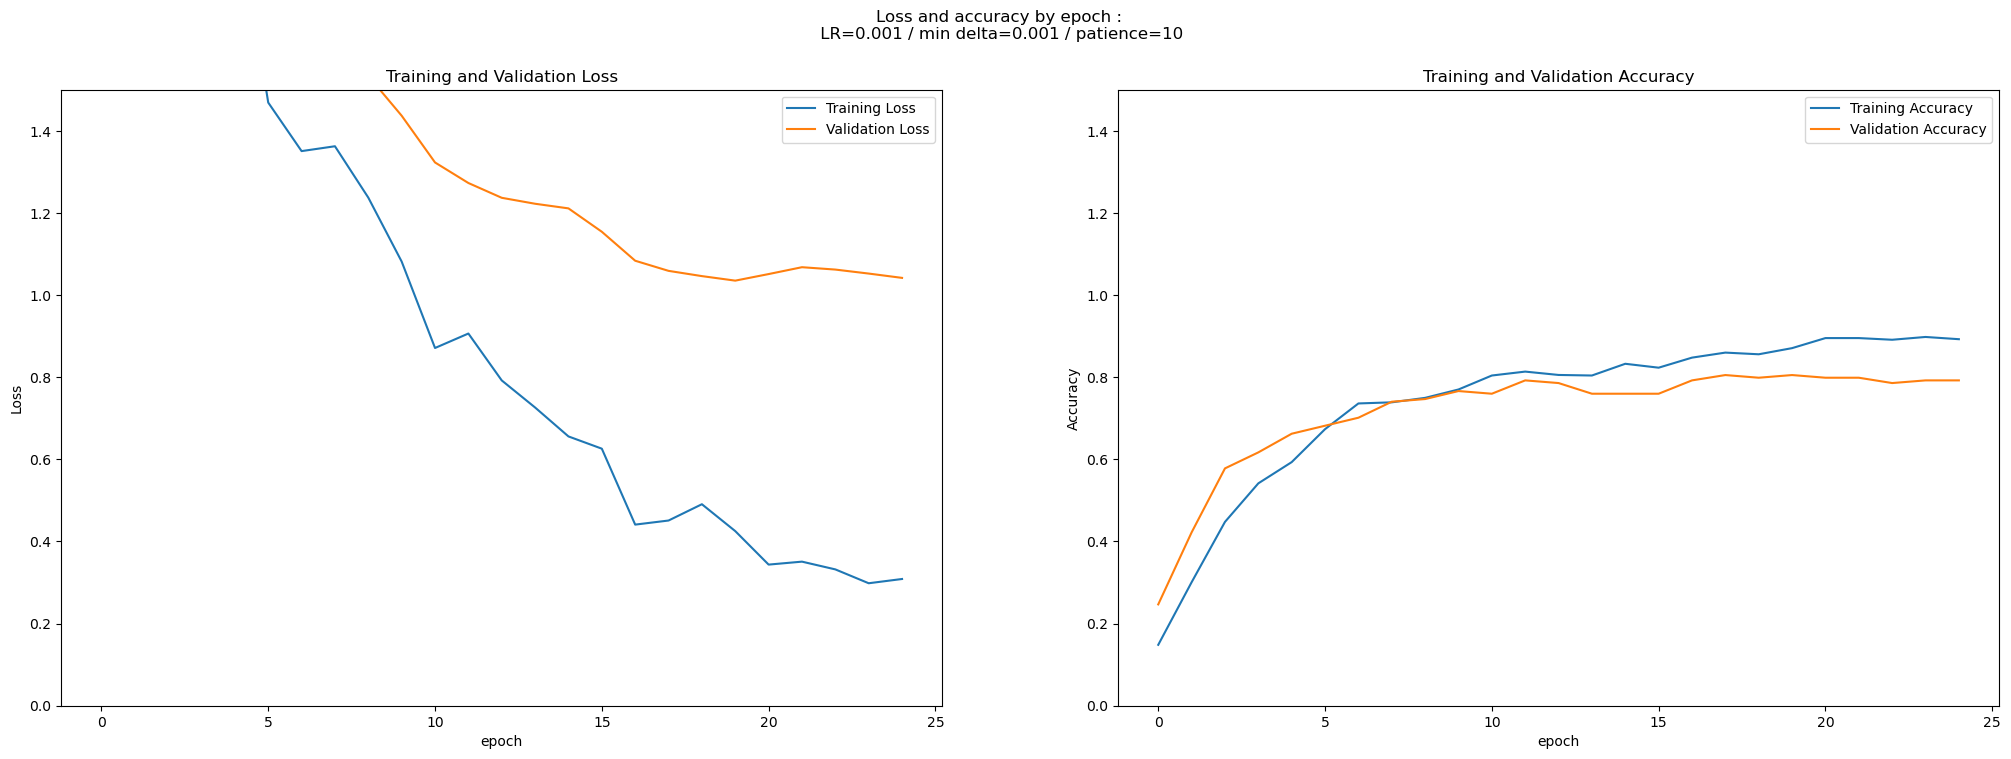

In [226]:
fig, ax = plt.subplots(1, 2, figsize=(25, 8))

# plotting loss
ax[0].plot(history_frame['loss'], label='Training Loss')
ax[0].plot(history_frame['val_loss'], label='Validation Loss')
ax[0].legend(loc='upper right')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,1.5])
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('epoch')

# plotting accuracy
ax[1].plot(history_frame['accuracy'], label='Training Accuracy')
ax[1].plot(history_frame['val_accuracy'], label='Validation Accuracy')
ax[1].legend(loc='upper right')
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim([0,1.5])
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('epoch')


plt.suptitle('Loss and accuracy by epoch :\n LR='+str(model.optimizer.learning_rate.numpy())+" / min delta="+str(min_improvement)+" / patience="+str(epochs_to_wait))
plt.show()

### Classification

In [228]:
#Predicting classes on our test dataset
final = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step


In [230]:
#preparing a dictionnary to replace numerical values with labels
class_names=X_test.class_names
replace_dict = {i: class_names[i] for i in range(len(class_names))}

#using dictionnary 
final_classes=[np.argmax(i) for i in final]
final_classes=[replace_dict[i] for i in final_classes]

In [232]:
#testing prediction
print("Predicted category:", final_classes[5])

Predicted category: Baby Care


In [234]:
#Evaluation of model viability
loss, accuracy = model.evaluate(X_test, verbose=0)
print("Test accuracy:", np.round(accuracy * 100, 2), "%")

Test accuracy: 73.91 %
